# WeRateDogs project


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering</a></li>
<li><a href="#assessing">Assessing</a></li>
<li><a href="#cleaning">Cleaning</a></li>
<li><a href="#analysis">Analysis</a></li>
</ul>

<a id='intro'></a>

## Introduction

> _They are good dogs Brent_ — WeRateDogs

With acid sarcasm and unbeatable cuteness,  [WeRateDogs](https://twitter.com/dog_rates?lang=es) has become a legendary Twitter account. In this project we will produce some insights with this account's data (which kind of dogs get best ratings and which kind of dogs get a bigger public support). For that we will have to first gather, asses and clean the messy datasets we work with.

Follow us in our travel to unlock the secrets hidden behind those hairy little pets!




<a id='gathering'></a>

## Gathering

Udacity has provided us with two files:
- Twitter_archive_enhanced.csv, a csv file which contains information of more than 2000 tweets
- image_predictions a tsv file stored in Udacity's site with the results of an image recognition neural network for thousands of images from WeRateDogs.

Aditionally we will leverage Twitter's API functionalities to complete some data missing in the 'twitter_archive_enhanced'.



In [1]:
#import libraries

import pandas as pd
import json
import tweepy
import requests
import os

In [2]:
# Read twitter_archive_enhanced into a DataFrame
twitter_df = pd.read_csv('twitter-archive-enhanced-2 (1).csv')
twitter_df.shape

(2356, 17)

In [3]:
# Import image_predictions file and store it in a .txt and read it into a DataFrame

# Request

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# Store the stream as text  

with open('image_prediction.tsv', 'w') as f:
    f.write(r.text)
    
# Save image_prediction.tsv to a DataFrame
images_df = pd.read_csv('image_prediction.tsv', sep='	')
images_df.head()
    

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [4]:
# Create an API object with Tweepy (I have hidden the keys after creating it it)

consumer_key = '....'
consumer_secret = '....'
access_token = '...'
access_secret = '...'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser = tweepy.parsers.JSONParser(), wait_on_rate_limit= True, wait_on_rate_limit_notify = True)



#Import tweet information with the API and write it into a txt

tweet_id_missing = []

with open('tweet_json.txt', 'w') as  f:
    for tweet_id in twitter_df.tweet_id:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            f.write(json.dumps(tweet) + '\n') #write one tweet per line,copied from Lakshay N in Udacity's forum
        except:
            tweet_id_missing.append(tweet_id)
       
        

In [5]:
# Read JSON into a DataFrame

selected_attr = []

with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        try:
            selected_attr.append({'tweet_id': json_data['id'],
                              'favorites': json_data['favorite_count'],
                              'retweets': json_data['retweet_count'],
                              'timestamp': json_data['created_at'],
                                  'expanded_url': json_data['entities']['media'][0]['expanded_url']})
        except:
            selected_attr.append({'tweet_id': json_data['id'],
                              'favorites': json_data['favorite_count'],
                              'retweets': json_data['retweet_count'],
                              'timestamp': json_data['created_at']})

tweet_selected_attr = pd.DataFrame(selected_attr, columns=['tweet_id', 'favorites', 'retweets', 'timestamp', 'expanded_url'])

In [6]:
tweet_selected_attr.head()

,tweet_id,favorites,retweets,timestamp,expanded_url
0,892420643555336193,36254,7719,Tue Aug 01 16:23:56 +0000 2017,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,31269,5706,Tue Aug 01 00:17:27 +0000 2017,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,23543,3781,Mon Jul 31 00:18:03 +0000 2017,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,39545,7877,Sun Jul 30 15:58:51 +0000 2017,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,37770,8492,Sat Jul 29 16:00:24 +0000 2017,https://twitter.com/dog_rates/status/891327558...


In [7]:
len(tweet_selected_attr)

2331

len(tweet_id_missing)


<a id='assessing'></a>

## Assesing

We are sure that we will have to work a little bit on our data. We know, for example, that we will have to get rid from some observations, as we are only interested original and rated tweets with photos. But we are sure that there will be some other problems that we will have to asses before being able to work with it.

Our objective is to have a dataset which is as complete, valid, accurate and consistent as possible but we are not planning on dive deep into it as we will just perform a superficial analysis on the data



We have 3 datasets:
<ul>
<li><a href="#twitter_df">twitter_df assessing</a></li>
<li><a href="#twitter_df">images_df assessing</a></li>
<li><a href="#tweet_selected_attr">tweet_selected_attr assessing</a></li>

</ul>

The analysis will be performed as follows:

- First we will visually and programmatically asses the DataFrame as a whole, spotting big structural and quality issues.
- After that, we will visually and programmatically asses smaller observationals units where we know or suspect that there might be quality issues.
- We will document all the issues that we find in a text cell at the bottom of this section.

<a id='twitter_df'></a>

### Assesing twitter_df DataFrame

This is our most important dataset and the one with the most amount of information, thus most work will happen here.



In [8]:
# Show a sample of 5 rows

twitter_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1861,675483430902214656,NaN,NaN,2015-12-12 01:12:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Rare shielded battle dog here. Very happy abou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675483430...,5,10,None,None,None,None,None
2091,670783437142401025,NaN,NaN,2015-11-29 01:56:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Flamboyant pup here. Probably poisonous. Won't...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670783437...,1,10,None,None,None,None,None
293,837820167694528512,NaN,NaN,2017-03-04 00:21:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Here's a pupper before and after being asked ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/837820167...,12,10,None,None,None,pupper,None
1723,680100725817409536,NaN,NaN,2015-12-24 19:00:23 +0000,"<a href=""https://about.twitter.com/products/tw...",This pupper is not coming inside until she cat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680100725...,11,10,None,None,None,pupper,None
1927,674051556661161984,NaN,NaN,2015-12-08 02:23:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She knits. Specializes in tobogg...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674051556...,10,10,Lucy,None,None,None,None


In [9]:
# Info

twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
# Describe numerical fields

twitter_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


> Rating denominator is 10,45, that shows  that there are some wrong values, as all values should be 10. 

In [11]:
# Rating denominators
twitter_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
# How many rows have a rating denominator different than 10
len(twitter_df[twitter_df.rating_denominator != 10])

23

In [13]:
#Show rows where rating denominator is different to 10

twitter_df[twitter_df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


There are 4 dog categories that we thought we could combine into one column to make a cleanier dataset, that is however difficult as the data below shows that there are dogs which can belong to more than one category.

In [14]:
# Find dogs wich are doggo and other category
doggo_and_other_dogs = twitter_df[['doggo', 'floofer', 'pupper', 'puppo']][((twitter_df['doggo'] == 'doggo') & ((twitter_df['floofer'] == 'floofer') | (twitter_df['pupper'] == 'pupper') | (twitter_df['puppo'] == 'puppo')))].index
twitter_df.loc[doggo_and_other_dogs].to_csv('doggo_and_others.csv')

In [15]:
# Find dogs wich are floofer and other category (except dogo as we checked tha above)

floofer_and_other_dogs = twitter_df[['floofer', 'pupper', 'puppo']][((twitter_df['floofer'] == 'floofer') & ((twitter_df['pupper'] == 'pupper') | (twitter_df['puppo'] == 'puppo')))].index

twitter_df.loc[floofer_and_other_dogs]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [16]:
#find dogs that are puppo and pupper
twitter_df[['puppo', 'pupper']][(twitter_df['puppo'] == 'puppo') & (twitter_df['pupper'] == 'pupper')]


,puppo,pupper


We might be missing some categories, we will look for observations which have some of the dog categories in the text but are not written down.


One of the biggest problems in the data set are the missing urls

In [17]:
# Expanded_urls is null

twitter_df[twitter_df['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [18]:
#How many expanded urls are null?
twitter_df['expanded_urls'].isnull().sum()

59

In [19]:
# How many of the expanded_url nulls are replies
(twitter_df['expanded_urls'].isnull() & twitter_df['in_reply_to_status_id'].notnull()).sum()

55

In [20]:
# How many of the expanded_url nulls are RT
(twitter_df['expanded_urls'].isnull() & twitter_df['retweeted_status_id'].notnull()).sum()

1

In [21]:
#Show me the 3 expanded url nulls which are not replies
twitter_df[twitter_df['expanded_urls'].isnull() & twitter_df['in_reply_to_status_id'].isnull() & twitter_df['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


> Most of the missing urls are due to the observation being either a retweet or a reply

In [22]:
# How does the source column look like
twitter_df.source.sample(5)

952     <a href="http://twitter.com/download/iphone" r...
2122    <a href="http://twitter.com/download/iphone" r...
2293    <a href="http://twitter.com/download/iphone" r...
2071    <a href="http://twitter.com/download/iphone" r...
1193    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

In [23]:
twitter_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [24]:
# Are there duplicated tweet_ids?
twitter_df.tweet_id.duplicated().sum()

0

tidyness:

- Is missing retweet an favorite data (which is in third table)
- dog categories could become just one column


quality:

- We want to delete the tweets without an image
- There are some wrong urls
- wrong denominators
- dog category values should be 1 /0
- Missing_names
- Missing expanded URLs
- NaN values in columns: 
    in_reply_to_status_id
    in_reply_to_user_id
    retweeted_status_id
    retweeted_status_user_id
    retweeted_status_timestamp
- Type of dogs categories would be easier with a numeric /boolean type
- Wrong 'name' values (a) or none
- We have to delete retweets and tweets with no image
- Timestamp datatype
- retweeted_status id is wronf +17
- Source urls contain href tag
- 460 should only have one category, floofer
- reset index

<a id='images_df'></a>

### Images DF

This Dataset shows the results of an image recognition algorithm. We are not goint to focus much on it as it will have only an accessory role in our analysis


In [25]:
images_df.shape

(2075, 12)

In [26]:
images_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [27]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
images_df.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
maillot                 1
harp                    1
coffee_mug              1
coil                    1
loupe                   1
Name: p1, Length: 378, dtype: int64

In [29]:
images_df.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama',
       'Chesapeake_Bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'Ibizan_hound', 'Border_collie', 'Labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'Airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 't

In [30]:
images_df[images_df['jpg_url'] == 'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False


In [31]:
images_df[images_df['tweet_id'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog



**Quality**

Column names are not expresive (p1 p1_conf etc)

Dog races values are written in different format (big and small letters) 

there are a lot of not dog species within the data,non existing animals, man built structures like the Fake Nessie foto (as killer_whale(

<a id='tweet_selected_attr'></a>

### Tweet Selected Attribute DF

**quality**

- timestamp is string instead of 



In [32]:
tweet_selected_attr.sample(2)

,tweet_id,favorites,retweets,timestamp,expanded_url
619,793286476301799424,25154,9398,Tue Nov 01 03:00:09 +0000 2016,https://twitter.com/dog_rates/status/793286476...
1870,674742531037511680,474,49,Thu Dec 10 00:08:50 +0000 2015,NaN


In [33]:
tweet_selected_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id        2331 non-null int64
favorites       2331 non-null int64
retweets        2331 non-null int64
timestamp       2331 non-null object
expanded_url    2059 non-null object
dtypes: int64(3), object(2)
memory usage: 91.2+ KB


In [34]:
tweet_selected_attr.tweet_id.duplicated().sum()

0

In [35]:
tweet_selected_attr.describe()

,tweet_id,favorites,retweets
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7571.698842,2707.934363
std,6.823170e+16,11751.934941,4579.348658
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1320.500000,548.000000
50%,7.182469e+17,3293.000000,1269.000000
75%,7.986692e+17,9268.500000,3146.500000
max,8.924206e+17,156421.000000,77940.000000


<a id='cleaning'></a>

## Cleaning

### Twitter_df cleaning


The list that we created in the previous section will function is this one as guide, we will separate each task in three sections:
- Define
- Code
- Test

Best practices say that we should start working on tidiness issues before starting with quality cleaning, but as lot of our quality work consist in deleting unneeded rows, we will perform it first, which we hope will reduce the amount of work to be done in other tasks

tidyness:

- Merge tweet_selected_attr to clean_twitter_df
- Create a new coluumn "mixed" for dogs which are more than one category, then  create a column "category" and aggreggate all dog categories there and delete the other columns


quality:
- Drop tweets which are replies or retweets

- Drop reply and tweet related columns:
    in_reply_to_status_id
    in_reply_to_user_id
    retweeted_status_id
    retweeted_status_user_id
    retweeted_status_timestamp
    
- Find out if all the tweets have a corresponding image; drop the ones that don't

- Drop original expanded_url column (we will use the new one extracted by the API, then, delete all rows with no urls

- Convert timestamp to datetime and delete the extra datetime

- Fix wrong denominators
   Group ratings change programmatically with a for loop
   Change manually individual ratings
   
- Change dogs with name 'a' to None

- Assign correct category to dogs which contain category name in text


As third table will be united to this, we will preform cleaning of attributes in twitter_df

In [36]:
# Copy twitter_df data_ser
clean_twitter_df = twitter_df.copy()
clean_twitter_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


**Define:**

Merge tweet_selected_attr to clean_twitter_df to see which rows have images, delete the ones which haven't and delete the jpg_column

**Code:**

In [37]:
#Join third table into clean_twitter_df
clean_twitter_df = clean_twitter_df.merge(tweet_selected_attr, on='tweet_id', how='left')


In [38]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp_x                   2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorites                     23

**Test**

In [39]:
clean_twitter_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,36254.0,7719.0,Tue Aug 01 16:23:56 +0000 2017,https://twitter.com/dog_rates/status/892420643...


**Define**

Drop tweets which are replies or retweets


In [40]:
# How many replies are in our data?

clean_twitter_df.in_reply_to_status_id.notnull().sum()

78

**Code:**

In [41]:
# Dropping replies

clean_twitter_df.drop(labels=(clean_twitter_df[clean_twitter_df.in_reply_to_status_id.notnull()].index), inplace=True)


In [42]:
# Dropping retweets

clean_twitter_df.drop(labels=(clean_twitter_df[clean_twitter_df.retweeted_status_id.notnull()].index), inplace=True)


**Test**


In [43]:
clean_twitter_df.in_reply_to_status_id.notnull().sum() 

0

In [44]:
clean_twitter_df.retweeted_status_id.notnull().sum()

0

**Define**

Drop reply and tweet related columns:
- in_reply_to_status_id
- in_reply_to_user_id
- retweeted_status_id
- retweeted_status_user_id
- retweeted_status_timestamp

**Code**

In [45]:
# Dropping reply and retweet columns
columns_to_delete = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
clean_twitter_df.drop(labels=columns_to_delete, axis=1, inplace=True)


**Test**

In [46]:
clean_twitter_df.head(1)

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,36254.0,7719.0,Tue Aug 01 16:23:56 +0000 2017,https://twitter.com/dog_rates/status/892420643...


**Define:**

Merge with images_df to see if every tweet has a corresponding image, delete the ones which hasn't.

**Code:**


In [47]:
#Create accessory data frame to merge image url to 
images_reduced_df = images_df[['tweet_id', 'jpg_url']]
images_reduced_df.columns = ['tweet_id', 'jpg_url']
images_reduced_df.head(1)

,tweet_id,jpg_url
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg


In [48]:
# Merge accessory image dataframe
clean_twitter_df = clean_twitter_df.merge(images_reduced_df, on='tweet_id', how='left')
clean_twitter_df.head(1)

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,36254.0,7719.0,Tue Aug 01 16:23:56 +0000 2017,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg


In [49]:
# Are there tweets without image?

clean_twitter_df[clean_twitter_df['jpg_url'].isnull()].sample(2)

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url
32,885518971528720385,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None,19241.0,3406.0,Thu Jul 13 15:19:09 +0000 2017,NaN,NaN
1522,678708137298427904,2015-12-20 22:46:44 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a wild field pupper. Lo...,https://vine.co/v/eQjxxYaQ60K,10,10,None,None,None,pupper,None,5544.0,2397.0,Sun Dec 20 22:46:44 +0000 2015,NaN,NaN


In [50]:
# Drop rows with no image
no_image_tweet = clean_twitter_df[clean_twitter_df['jpg_url'].isnull()].index
clean_twitter_df.drop(no_image_tweet, inplace=True)


**Test:**

In [51]:
clean_twitter_df[clean_twitter_df['jpg_url'].isnull()]

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url


**Define:**

Drop original expanded_url column (we will use the one proceeding from the API file)

Drop rows without url




> We will first assess the issue

In [52]:
#how many rows have different urls

clean_twitter_df[clean_twitter_df['expanded_url'] != clean_twitter_df['expanded_urls']]

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,37770.0,8492.0,Sat Jul 29 16:00:24 +0000 2017,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,11073.0,1852.0,Fri Jul 28 16:27:12 +0000 2017,https://twitter.com/dog_rates/status/890971913...,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,61092.0,17222.0,Fri Jul 28 00:22:40 +0000 2017,https://twitter.com/dog_rates/status/890729181...,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg
10,890006608113172480,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,None,None,None,28805.0,6691.0,Wed Jul 26 00:31:25 +0000 2017,https://twitter.com/dog_rates/status/890006608...,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg
13,889638837579907072,2017-07-25 00:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ted. He does his best. Sometimes that'...,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,None,None,None,None,25394.0,4098.0,Tue Jul 25 00:10:02 +0000 2017,https://twitter.com/dog_rates/status/889638837...,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,671347597085433856,2015-11-30 15:18:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lola. She was not fully prepared for t...,https://twitter.com/dog_rates/status/671347597...,9,10,Lola,None,None,None,None,925.0,413.0,Mon Nov 30 15:18:34 +0000 2015,https://twitter.com/dog_rates/status/671347597...,https://pbs.twimg.com/media/CVEbFDRWsAAkN_7.jpg
1820,670995969505435648,2015-11-29 16:01:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yea I can't handle this job anymore your dogs ...,https://twitter.com/dog_rates/status/670995969...,12,10,None,None,None,None,None,1071.0,283.0,Sun Nov 29 16:01:20 +0000 2015,https://twitter.com/dog_rates/status/670995969...,https://pbs.twimg.com/media/CU_bRIEWcAAUVC7.jpg
1831,670807719151067136,2015-11-29 03:33:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Say hello to Andy. He can balance on one foot,...",https://twitter.com/dog_rates/status/670807719...,11,10,Andy,None,None,None,None,1122.0,468.0,Sun Nov 29 03:33:17 +0000 2015,https://twitter.com/dog_rates/status/670807719...,https://pbs.twimg.com/media/CU8v-rdXIAId12Z.jpg
1949,668633411083464705,2015-11-23 03:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Churlie. He likes bagels. 10/10 https:...,https://twitter.com/dog_rates/status/668633411...,10,10,Churlie,None,None,None,None,2698.0,1548.0,Mon Nov 23 03:33:22 +0000 2015,https://twitter.com/dog_rates/status/668633411...,https://pbs.twimg.com/media/CUd2ieCUcAAexyT.jpg


In [53]:
# Show rows where expanded_url is different to url

clean_twitter_df[clean_twitter_df['expanded_url'] != clean_twitter_df['expanded_urls'] ][['expanded_url', 'expanded_urls']]

,expanded_url,expanded_urls
4,https://twitter.com/dog_rates/status/891327558...,https://twitter.com/dog_rates/status/891327558...
6,https://twitter.com/dog_rates/status/890971913...,"https://gofundme.com/ydvmve-surgery-for-jax,ht..."
7,https://twitter.com/dog_rates/status/890729181...,https://twitter.com/dog_rates/status/890729181...
10,https://twitter.com/dog_rates/status/890006608...,https://twitter.com/dog_rates/status/890006608...
13,https://twitter.com/dog_rates/status/889638837...,https://twitter.com/dog_rates/status/889638837...
...,...,...
1805,https://twitter.com/dog_rates/status/671347597...,https://twitter.com/dog_rates/status/671347597...
1820,https://twitter.com/dog_rates/status/670995969...,https://twitter.com/dog_rates/status/670995969...
1831,https://twitter.com/dog_rates/status/670807719...,https://twitter.com/dog_rates/status/670807719...
1949,https://twitter.com/dog_rates/status/668633411...,https://twitter.com/dog_rates/status/668633411...


In [54]:
# export CSV with different urls to assess it visually better in excel

clean_twitter_df[clean_twitter_df.expanded_urls != clean_twitter_df.expanded_url].to_csv(path_or_buf='different_urls.csv')

**Code:**

In [55]:
#drop expanded_urls
clean_twitter_df.drop('expanded_urls', axis=1, inplace=True)
clean_twitter_df

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,36254.0,7719.0,Tue Aug 01 16:23:56 +0000 2017,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,31269.0,5706.0,Tue Aug 01 00:17:27 +0000 2017,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,23543.0,3781.0,Mon Jul 31 00:18:03 +0000 2017,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,39545.0,7877.0,Sun Jul 30 15:58:51 +0000 2017,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,37770.0,8492.0,Sat Jul 29 16:00:24 +0000 2017,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5,10,None,None,None,None,None,96.0,39.0,Mon Nov 16 00:24:50 +0000 2015,https://twitter.com/dog_rates/status/666049248...,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
2093,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6,10,a,None,None,None,None,272.0,132.0,Mon Nov 16 00:04:52 +0000 2015,https://twitter.com/dog_rates/status/666044226...,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
2094,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9,10,a,None,None,None,None,112.0,41.0,Sun Nov 15 23:21:54 +0000 2015,https://twitter.com/dog_rates/status/666033412...,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
2095,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7,10,a,None,None,None,None,121.0,42.0,Sun Nov 15 23:05:30 +0000 2015,https://twitter.com/dog_rates/status/666029285...,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg


In [56]:
# Drop rows with empty urls
empty_url = clean_twitter_df[clean_twitter_df['expanded_url'].isnull()].index
clean_twitter_df.drop(empty_url, inplace = True)


**Test:**

In [57]:
clean_twitter_df[clean_twitter_df['expanded_url'].isnull()]

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url


**Define:**

Convert timestamp to datetime and delete the extra column


In [58]:
# show timestamps
clean_twitter_df[['timestamp_x', 'timestamp_y']]

,timestamp_x,timestamp_y
0,2017-08-01 16:23:56 +0000,Tue Aug 01 16:23:56 +0000 2017
1,2017-08-01 00:17:27 +0000,Tue Aug 01 00:17:27 +0000 2017
2,2017-07-31 00:18:03 +0000,Mon Jul 31 00:18:03 +0000 2017
3,2017-07-30 15:58:51 +0000,Sun Jul 30 15:58:51 +0000 2017
4,2017-07-29 16:00:24 +0000,Sat Jul 29 16:00:24 +0000 2017
...,...,...
2092,2015-11-16 00:24:50 +0000,Mon Nov 16 00:24:50 +0000 2015
2093,2015-11-16 00:04:52 +0000,Mon Nov 16 00:04:52 +0000 2015
2094,2015-11-15 23:21:54 +0000,Sun Nov 15 23:21:54 +0000 2015
2095,2015-11-15 23:05:30 +0000,Sun Nov 15 23:05:30 +0000 2015


In [59]:
# convert to datetime
clean_twitter_df['timestamp_x'] = pd.to_datetime(clean_twitter_df['timestamp_x'])
clean_twitter_df['timestamp_y'] = pd.to_datetime(clean_twitter_df['timestamp_y'])
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2096
Data columns (total 16 columns):
tweet_id              1964 non-null int64
timestamp_x           1964 non-null datetime64[ns, UTC]
source                1964 non-null object
text                  1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
doggo                 1964 non-null object
floofer               1964 non-null object
pupper                1964 non-null object
puppo                 1964 non-null object
favorites             1964 non-null float64
retweets              1964 non-null float64
timestamp_y           1964 non-null datetime64[ns, UTC]
expanded_url          1964 non-null object
jpg_url               1964 non-null object
dtypes: datetime64[ns, UTC](2), float64(2), int64(3), object(9)
memory usage: 260.8+ KB


**Code:**

In [60]:
# Are there differences?
clean_twitter_df[clean_twitter_df['timestamp_x'] != clean_twitter_df['timestamp_y']]

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,timestamp_y,expanded_url,jpg_url


In [61]:
# Delete one timestamp column
clean_twitter_df.drop('timestamp_y', axis=1,  inplace = True)


**Test:**

In [62]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1964 non-null int64
timestamp_x           1964 non-null datetime64[ns, UTC]
source                1964 non-null object
text                  1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
doggo                 1964 non-null object
floofer               1964 non-null object
pupper                1964 non-null object
puppo                 1964 non-null object
favorites             1964 non-null float64
retweets              1964 non-null float64
expanded_url          1964 non-null object
jpg_url               1964 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 245.5+ KB


In [63]:
clean_twitter_df.columns

Index(['tweet_id', 'timestamp_x', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'favorites', 'retweets', 'expanded_url', 'jpg_url'],
      dtype='object')

**Define:**

Fix wrong ratings by:

   programmatically calculate the individual rating of the group ratings with a for loop

   Change manually individual ratings

**Code:**



In [64]:
# export CSV to visually asses wrong denominators
clean_twitter_df[clean_twitter_df.rating_denominator != 10].to_csv(path_or_buf='wrong_denominator.csv')

In [65]:
clean_twitter_df.shape[0]

1964

In [66]:
# Change ratinggs which are multiplieres.
multiple_denominators_indices = [339, 700, 904, 985, 1011, 1036, 1129, 1210, 1399, 1540, 1602]

for indice in multiple_denominators_indices:
    coeficiente = clean_twitter_df.loc[indice]['rating_denominator'] / 10
    clean_twitter_df['rating_numerator'][indice] = clean_twitter_df.loc[indice]['rating_numerator'] / coeficiente
    clean_twitter_df['rating_denominator'][indice] = clean_twitter_df.loc[indice]['rating_denominator'] / coeficiente
    


    

C:\Users\judaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\judaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [67]:
# Manually adapt wrong ratings
clean_twitter_df.loc[853, ['rating_numerator', 'rating_denominator']] = 14, 10
clean_twitter_df.loc[948, ['rating_numerator', 'rating_denominator']] = 13, 10
clean_twitter_df.loc[1426, ['rating_numerator', 'rating_denominator']] = 10, 10
clean_twitter_df.loc[2076, ['rating_numerator', 'rating_denominator']] = 9, 10




In [68]:
clean_twitter_df.loc[[403, 1056]]

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,expanded_url,jpg_url
403,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,None,None,None,None,5448.0,1470.0,https://twitter.com/dog_rates/status/810984652...,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
1056,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",45,50,None,None,None,None,None,2417.0,639.0,https://twitter.com/dog_rates/status/709198395...,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg


In [69]:
#Manually drop wrong ratings:
no_rating = [403, 1056]
clean_twitter_df.drop(no_rating,inplace=True)
clean_twitter_df[clean_twitter_df['rating_denominator'] != 10]

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,expanded_url,jpg_url


**Test:**

In [70]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 245.2+ KB


In [71]:
clean_twitter_df.loc[[853, 948, 1426, 2076]][['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
853,14,10
948,13,10
1426,10,10
2076,9,10


In [72]:
# Test if they have beeen changed
clean_twitter_df.loc[multiple_denominators_indices]

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,expanded_url,jpg_url
339,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,12,10,None,None,None,None,None,12385.0,3282.0,https://twitter.com/dog_rates/status/820690176...,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg
700,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,11,10,None,None,None,None,None,4822.0,2232.0,https://twitter.com/dog_rates/status/758467244...,https://pbs.twimg.com/ext_tw_video_thumb/75846...
904,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,12,10,this,None,None,None,None,3826.0,1259.0,https://twitter.com/dog_rates/status/731156023...,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg
985,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,10,10,Bluebert,None,None,None,None,2363.0,207.0,https://twitter.com/dog_rates/status/716439118...,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg
1011,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,11,10,None,None,None,None,None,2820.0,738.0,https://twitter.com/dog_rates/status/713900603...,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg
1036,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,10,10,None,None,None,None,None,2305.0,555.0,https://twitter.com/dog_rates/status/710658690...,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg
1129,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,12,10,a,None,None,None,None,2917.0,911.0,https://twitter.com/dog_rates/status/704054845...,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg
1210,697463031882764288,2016-02-10 16:51:59+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,11,10,None,None,None,None,None,3417.0,1396.0,https://twitter.com/dog_rates/status/697463031...,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg
1399,684222868335505415,2016-01-05 04:00:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,11,10,None,None,None,None,None,3813.0,1369.0,https://twitter.com/dog_rates/status/684222868...,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg
1540,677716515794329600,2015-12-18 05:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,12,10,None,None,None,None,None,3019.0,966.0,https://twitter.com/dog_rates/status/677716515...,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg


In [73]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


**Define:**

Change dogs with name 'a' to None


In [74]:
# Export csv with wrong name
clean_twitter_df[clean_twitter_df.name == 'a'].to_csv(path_or_buf='name_is_a.csv')
len(clean_twitter_df[clean_twitter_df.name == 'a'])

55

In [75]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


**Code:**

In [76]:
#change a to none

clean_twitter_df.name.replace('a', 'None', inplace=True)



In [77]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


**Test:**

In [78]:
clean_twitter_df[clean_twitter_df.name == 'a']

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,expanded_url,jpg_url


In [79]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


**Define:**

Assign tweets a dog category if the category is mentioned in the text column

In [80]:
# Export CSVs to visually inspect categories with None value but with a dog type in their text

clean_twitter_df[clean_twitter_df.text.str.contains('pupper') & (clean_twitter_df.pupper == 'None')].to_csv(path_or_buf='pupper_intext.csv')

clean_twitter_df[clean_twitter_df.text.str.contains('floofer') & (clean_twitter_df.floofer == 'None')].to_csv(path_or_buf='floofer_intext.csv')

clean_twitter_df[clean_twitter_df.text.str.contains('puppo') & (clean_twitter_df.puppo == 'None')].to_csv(path_or_buf='puppo_intext.csv')

clean_twitter_df[clean_twitter_df.text.str.contains('doggo') & (clean_twitter_df.doggo == 'None')].to_csv(path_or_buf='doggo_intext.csv')



**Code:**

In [81]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


In [82]:
#Add doggo

to_add_doggo = [215, 370, 614, 729, 778, 904]

for perro in to_add_doggo:
    clean_twitter_df.loc[perro, 'doggo'] = 'doggo'

In [83]:
# Add puppo

to_add_puppo = [75, 92, 114, 143, 426,]

for perro in to_add_puppo:
    clean_twitter_df.loc[perro, 'puppo'] = 'puppo'

In [84]:
# Add pupper

to_add_pupper = [50, 784, 813, 877, 1003, 1011, 1036, 1047, 1286, 1399, 1400, 1407, 1472, 1474, 1586, 1602, 1605, 1619, 1652, 1678, 1888]

for perro in to_add_pupper:
    clean_twitter_df.loc[perro, 'pupper'] = 'pupper'

In [85]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
doggo                 1962 non-null object
floofer               1962 non-null object
pupper                1962 non-null object
puppo                 1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(9)
memory usage: 325.2+ KB


**Test:**

In [86]:
# Test doggo


for perro in to_add_doggo:
    print(clean_twitter_df.loc[perro, ['text','doggo']])

text     Here we have some incredible doggos for #K9Vet...
doggo                                                doggo
Name: 215, dtype: object
text     Meet Jack. He's one of the rare doggos that do...
doggo                                                doggo
Name: 370, dtype: object
text     You need to watch these two doggos argue throu...
doggo                                                doggo
Name: 614, dtype: object
text     Here we are witnessing an isolated squad of bo...
doggo                                                doggo
Name: 729, dtype: object
text     This is Dietrich. He hops at random. Other dog...
doggo                                                doggo
Name: 778, dtype: object
text     Say hello to this unbelievably well behaved sq...
doggo                                                doggo
Name: 904, dtype: object


In [87]:
# Test pupper


for perro in to_add_pupper:
    print(clean_twitter_df.loc[perro, ['text','pupper']])

text      This is Gary. He couldn't miss this puppertuni...
pupper                                               pupper
Name: 50, dtype: object
text      This is one of the most reckless puppers I've ...
pupper                                               pupper
Name: 784, dtype: object
text      This is Arlen and Thumpelina. They are best pa...
pupper                                               pupper
Name: 813, dtype: object
text      Everybody stop what you're doing and watch the...
pupper                                               pupper
Name: 877, dtype: object
text      Here are two lil cuddly puppers. Both 12/10 wo...
pupper                                               pupper
Name: 1003, dtype: object
text      Happy Saturday here's 9 puppers on a bench. 99...
pupper                                               pupper
Name: 1011, dtype: object
text      Here's a brigade of puppers. All look very pre...
pupper                                               pupper
Name: 103

In [88]:
# Test puppo

for perro in to_add_puppo:
    print(clean_twitter_df.loc[perro, ['text','puppo']])

text     Meet Venti, a seemingly caffeinated puppoccino...
puppo                                                puppo
Name: 75, dtype: object
text     Say hello to Lassie. She's celebrating #PrideM...
puppo                                                puppo
Name: 92, dtype: object
text     This is Lili. She can't believe you betrayed h...
puppo                                                puppo
Name: 114, dtype: object
text     I have stumbled puppon a doggo painting party....
puppo                                                puppo
Name: 143, dtype: object
text     This is Duke. He is not a fan of the pupporazz...
puppo                                                puppo
Name: 426, dtype: object


**Define:**

Following the rules of tidy data, each variable should be only one column so we want all the dog category columns (doggo, floofer, pupper, puppo) to become one. The problem is that there are some dogs which are more than one category so we will have to do the following:

- Convert values to integer (0 / 1)
- Create a new column ' mixed' if the dog is from two categories
- If the dog appears in 'mixed' category, convert values in other categories to 0
- define a function that assigns a value to a dog_type column and returns it depending on the value in the other category columns (got the idea from here: https://stackoverflow.com/a/53505512)
- pass the function
- delete the old columns


**Code:**

In [89]:
# Replace dog categories with 1 0

clean_twitter_df.doggo = clean_twitter_df.doggo.replace(['None', 'doggo'], [0, 1])

clean_twitter_df.pupper = clean_twitter_df.pupper.replace(['None', 'pupper'], [0, 1])

clean_twitter_df.puppo = clean_twitter_df.puppo.replace(['None', 'puppo'], [0, 1])

clean_twitter_df.floofer = clean_twitter_df.floofer.replace(['None', 'floofer'], [0, 1])



In [90]:
# Create a new column " mixed" for rows which have one or more category
clean_twitter_df['mixed'] = clean_twitter_df['doggo'] + clean_twitter_df['pupper'] + clean_twitter_df['puppo'] + clean_twitter_df['floofer']
clean_twitter_df['mixed'].replace([0, 1, 2],[0,0,1], inplace=True)
clean_twitter_df['mixed'].value_counts()

0    1951
1      11
Name: mixed, dtype: int64

In [91]:
# List of indices for rows where mixed = 1

mixed_tweets = list(clean_twitter_df[clean_twitter_df['mixed'] == 1].index)
mixed_tweets

[143, 154, 161, 358, 416, 446, 536, 689, 748, 848, 897]

In [92]:
# Change value of dog category to 0 if 'mixed' == 1

for indice in mixed_tweets:
    clean_twitter_df.loc[indice, ['doggo', 'pupper', 'puppo', 'floofer']] = 0
    

In [93]:
# Are there dog categories 0 when mixed is 1?
clean_twitter_df.loc[mixed_tweets] 

,tweet_id,timestamp_x,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,expanded_url,jpg_url,mixed
143,858843525470990336,2017-05-01 00:40:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I have stumbled puppon a doggo painting party....,13,10,None,0,0,0,0,15042.0,3321.0,https://twitter.com/dog_rates/status/858843525...,https://pbs.twimg.com/media/C-s5oYZXkAAMHHq.jpg,1
154,855851453814013952,2017-04-22 18:31:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,13,10,None,0,0,0,0,44467.0,17374.0,https://twitter.com/dog_rates/status/855851453...,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1
161,854010172552949760,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",11,10,None,0,0,0,0,15867.0,3055.0,https://twitter.com/dog_rates/status/854010172...,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1
358,817777686764523521,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",13,10,Dido,0,0,0,0,10917.0,2743.0,https://twitter.com/dog_rates/status/817777686...,https://pbs.twimg.com/ext_tw_video_thumb/81777...,1
416,808106460588765185,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,12,10,None,0,0,0,0,8971.0,2255.0,https://twitter.com/dog_rates/status/808106460...,https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg,1
446,801115127852503040,2016-11-22 17:28:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,12,10,Bones,0,0,0,0,8252.0,2156.0,https://twitter.com/dog_rates/status/801115127...,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1
536,785639753186217984,2016-10-11 00:34:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,10,10,Pinot,0,0,0,0,7985.0,2283.0,https://twitter.com/dog_rates/status/785639753...,https://pbs.twimg.com/media/CucnLmeWAAALOSC.jpg,1
689,759793422261743616,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",12,10,Maggie,0,0,0,0,6008.0,1933.0,https://twitter.com/dog_rates/status/759793422...,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,1
748,751583847268179968,2016-07-09 01:08:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,5,10,None,0,0,0,0,4417.0,1109.0,https://twitter.com/dog_rates/status/751583847...,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1
848,741067306818797568,2016-06-10 00:39:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,12,10,just,0,0,0,0,9499.0,3095.0,https://twitter.com/dog_rates/status/741067306...,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1


In [94]:
# Define function that assigns a value to dog_type depending on dog category

def to_dogtype(row):
    if row['doggo'] == 1:
        row['dog_type'] = 'doggo'
    elif row['pupper'] == 1:
         row['dog_type'] = 'pupper'
    elif row['puppo'] == 1:
         row['dog_type'] = 'puppo'
    elif row['floofer'] == 1:
         row['dog_type'] = 'floofer'  
    elif row['mixed'] == 1:
         row['dog_type'] = 'mixed'
    else:
        row['dog_type'] = 'None'
    return row['dog_type']


In [95]:
# Apply to_dogtype function to create dog_type column

clean_twitter_df['dog_type'] = clean_twitter_df.apply(to_dogtype, axis=1)



In [96]:
#Drop dogtype columns

clean_twitter_df.drop(['doggo', 'floofer', 'pupper', 'puppo', 'mixed'], axis = 1, inplace = True)

**Test:**



In [97]:
# Test if Dog_type worked

clean_twitter_df['dog_type'].value_counts()

None       1629
pupper      222
doggo        67
puppo        26
mixed        11
floofer       7
Name: dog_type, dtype: int64

In [98]:
clean_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id              1962 non-null int64
timestamp_x           1962 non-null datetime64[ns, UTC]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
favorites             1962 non-null float64
retweets              1962 non-null float64
expanded_url          1962 non-null object
jpg_url               1962 non-null object
dog_type              1962 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(6)
memory usage: 279.3+ KB


In [99]:
# Save cleaned file
clean_twitter_df.to_csv('twitter_archive_master.csv')

In [100]:
images_df.to_csv('twitter_images.csv')

<a id='Analysis'></a>

## Analysis

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

**Did the success of "They're Good Dogs Brent" increase the visibility of the Tweet account??**

WeRateDogs is internationally known due to the viralization of its meme “They’re Good Dogs Brent” . We can imagine that this Tweet had a positive effect in the account visibility what our data seems to confirm.

In [102]:
fav_rt_time = clean_twitter_df.groupby( pd.Grouper(key='timestamp_x',freq='m'))[['favorites', 'retweets']].mean()
fav_rt_time

,favorites,retweets
timestamp_x,,
2015-11-30 00:00:00+00:00,1183.850847,489.132203
2015-12-31 00:00:00+00:00,3253.701950,1326.857939
2016-01-31 00:00:00+00:00,3714.222892,1354.433735
2016-02-29 00:00:00+00:00,4045.490741,1441.953704
2016-03-31 00:00:00+00:00,4248.794872,1461.786325
2016-04-30 00:00:00+00:00,4382.648148,1427.592593
2016-05-31 00:00:00+00:00,5797.250000,1967.928571
2016-06-30 00:00:00+00:00,9938.088608,3951.379747
2016-07-31 00:00:00+00:00,6544.839080,2224.965517


C:\Users\judaf\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


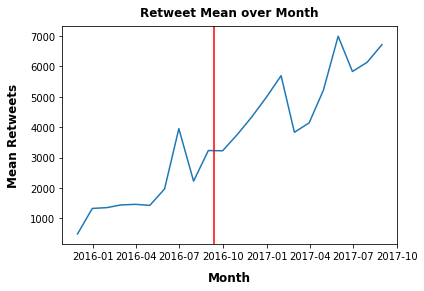

In [103]:
#Mean retweets over time

plt.plot(fav_rt_time.index, fav_rt_time['retweets'])

plt.title('Retweet Mean over Month', pad=10, weight='bold', size=12)

plt.xlabel('Month', labelpad=10, weight='bold', size=12)

plt.ylabel('Mean Retweets', labelpad=10, weight='bold', size=12)

good_dogs_brent_month = pd.to_datetime('09/12/2016')

plt.axvline(good_dogs_brent_month, color= 'r')


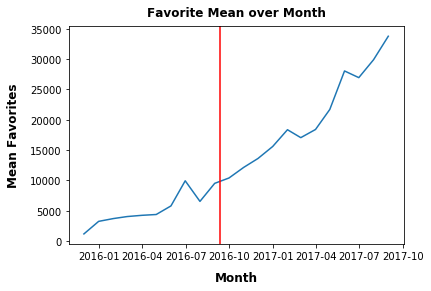

In [104]:
#Mean favorites over time

plt.plot(fav_rt_time.index, fav_rt_time['favorites'])

plt.title('Favorite Mean over Month', pad=10, weight='bold', size=12)

plt.xlabel('Month', labelpad=10, weight='bold', size=12)

plt.ylabel('Mean Favorites', labelpad=10, weight='bold', size=12)
good_dogs_brent_month = pd.to_datetime('09/12/2016')

plt.axvline(good_dogs_brent_month, color= 'r')

The line plots above show the mean of Retweets and Favorites per tweet every month from January 2016 until October 2017, The read line marks the date of the publishing of the  Brent Tweet.

In the figures we can see that, following a period of steady but slow growth, the average favorites and retweet per tweet explode after  September 2016.

This insights have to be taken with a degree of scepticism as data does not include all tweets but only the ones which agree with the project requirements.

